In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import sklearn
import random
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from distcorr import distcorr

In [3]:
iris = load_iris()

In [4]:
# Filter the data and convert to numpy

dataset = iris['data']
dataset = np.asarray(dataset)

In [5]:
training_features = dataset[:, :-1]
target_features = dataset[:, -1]

In [6]:
average_value = np.median(target_features)
average_value

1.3

In [7]:
# Create bins for stratified split

bins = np.linspace(0, 6)
y_binned = np.digitize(target_features, bins)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(training_features, target_features, random_state=0, stratify=y_binned)

In [9]:
x_train = torch.from_numpy(x_train)
x_train = x_train.view(1, x_train.shape[0], 3)

x_test = torch.from_numpy(x_test)
x_test = x_test.view(1, x_test.shape[0], 3)

y_train = torch.from_numpy(y_train)
y_train = y_train.view(1, y_train.shape[0], 1)

y_test = torch.from_numpy(y_test)
y_test = y_test.view(1, y_test.shape[0], 1)

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=3, out_features=2)
        self.enc2 = nn.Linear(in_features=2, out_features=1)
    
    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = self.enc2(x)
        return x

In [11]:
# Create a seed for consistent output during experimentation

random.seed(1)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()

In [12]:
NUM_EPOCHS = 500
LEARNING_RATE = 0.01
BATCH_SIZE = 120

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [14]:
def train(net):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data, target in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(data.double())
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if epoch == NUM_EPOCHS-1:
                for i in range(len(data)):
                    print("Input: ", data[i])
                    print("Target: ", target[i])
                    print("Outputs: ", outputs[i])

        loss = running_loss / len(x_train)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'
            .format(epoch+1, NUM_EPOCHS, loss))
    return train_loss

def test(net):

    net.eval()

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0
        for data, target in zip(x_test, y_test):
            outputs = net(data.double())
            loss = criterion(outputs, target)
            running_loss += loss.item()

            for i in range(len(data)):
                print("Input: ", data[i])
                print("Target: ", target[i])
                print("Outputs: ", outputs[i])
                
        loss = running_loss / len(x_test)
        test_loss.append(loss)
        print('Test Loss: {:.3f}'.format(loss))

        return test_loss
        

In [ ]:
train_loss1 = train(net)


In [ ]:
plt.figure()
plt.plot(train_loss1)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
test_result = test(net)

In [ ]:
torch.save(net, './model1')

In [15]:
load_model = torch.load('model1')
unseen_predicted = load_model(x_test.double())

unseen_predicted = unseen_predicted.reshape(-1, 1).detach().numpy()
unseen_original = y_test.reshape(-1, 1).detach().numpy()
comparison_column = x_test.detach().numpy()[:, :, 2].reshape(-1, 1)

In [16]:
print(scipy.stats.pearsonr(comparison_column.flatten(), unseen_original.flatten()))
print(scipy.stats.pearsonr(comparison_column.flatten(), unseen_predicted.flatten()))

(0.9526001916624599, 3.433386152802958e-20)
(0.9978115074157252, 4.510941510393908e-44)


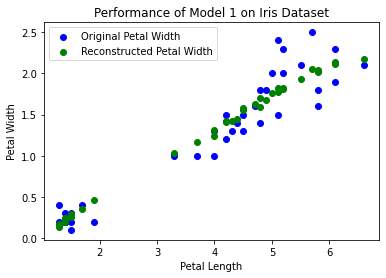

In [20]:
plt.scatter(comparison_column, unseen_original, color='blue', label='Original Petal Width')
plt.scatter(comparison_column, unseen_predicted, color='green', label='Reconstructed Petal Width')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('Performance of Model 1 on Iris Dataset')
plt.legend()
plt.savefig('model1Results.pdf')
plt.show()


In [ ]:
from scipy import stats
from statsmodels.stats import weightstats as stets

ttest, pval = stats.ttest_ind(unseen_original, unseen_predicted)
print("P-value for significance: ", pval)
print("TTEST: ", ttest)

if pval<0.05:
    print("Conclusion: Reject Null Hypothesis")
else:
    print("Conclusion: Accept Null Hypothesis")

In [ ]:
# new_dataset = np.concatenate((features, new_column.detach().numpy()), axis=1)
# np.set_printoptions(precision=2, suppress=True)
# new_dataset
# np.savetxt('first_iris.csv', new_dataset)